# MUMIA: PROCESAMIENTO DEL LENGUAJE NATURAL
## Caso grupal: Etiquetado morfosintáctico
## GRUPO 4 - EQUIPO 11 - PLN_11
## INTEGRANTES:

+ **Ignacio López Pérez**  
+ **Jose Angel de Bustos Pérez** 
+ **Marcos García Padrón**
+ **Jorge Valenzuela Jimenez**
+ **Javier Peralta Muñoz**


# Enunciado de la práctica

Se proporciona un corpus y se pide lo siguiente:

1. En esta primera parte de la actividad tienes que implementar en Python el etiquetador morfosintáctico basado en un HMM bigrama a partir de un corpus etiquetado.

2. En esta segunda parte de la actividad tienes que implementar en Python un programa que permita calcular la mejor secuencia de etiquetas para una oración, dicho de otro modo, realizar el etiquetado morfosintáctico de la oración. Para ello debes utilizar el etiquetador que has construido en la parte 1 de esta actividad y aplicar el algoritmo de Viterbi. La oración para la que se debe realizar el etiquetado mofosintáctico es: 

> **Habla con el enfermo grave de trasplantes**.

3. Una vez hayas creado el etiquetador morfosintáctico y lo hayas utilizado para etiquetar la oración "**Habla con el enfermo grave de trasplantes.**", reflexiona sobre los resultados obtenidos, interprétalos y analiza el rendimiento del etiquetador creado y sus limitaciones. Para ello responde de forma razonada a las siguientes preguntas:

  * ¿Es correcto el etiquetado morfosintáctico que has obtenido? Indica por qué.
  * Indica el resultado de etiquetar la oración "**El enfermo grave habla de trasplantes.**" utilizando el etiquetador morfosintáctico. ¿Es correcto el etiquetado morfosintáctico que has obtenido? Indica por qué.
  * ¿Cuáles son las limitaciones del analizador morfosintáctico que has creado?
  * ¿Qué posibles mejoras se podrían aplicar para mejorar el rendimiento del etiquetador morfosintáctico creado?


 # Funciones auxiliares
 
 Con el fin de aumentar la legibilidad de la práctica vamos a incluir en esta sección las funciones auxiliares que vamos a utilizar.
 
 ## Etiquetador morfosintáctico
 
 Lo primero que hacemos es crear dos funciones auxiliares para:
 
 * Crear la matriz de transición de probabilidades
 * Crear la matriz de observación de lemas

In [14]:
%config IPCompleter.greedy=True
import re
import numpy as np

'''   
   Función: Generar y popular los valores en las matrices de observación y transición
   Parámetros:
             - lines: Lineas del corpus pasado en el fichero proporcionado
             - IN/OUT: typeTransictionDictionary: Estructura final para la matriz de transición de probabilidades
             - IN/OUT: typeObservationDictionary: Estructura final para la matriz de observación de lemas
             
   Output:
             - Diccionario con la matriz de transición de probabilidades
             - Diccionario con la matriz de observación de lemas
'''

def populateMatrix(lines, typeTransictionDictionary, typeObservationDictionary):
    # Diccionario donde se almacenará la matriz de transición de probabilidades
    typeTransictionDictionary = {}
    
    # Diccionario donde se almacenará la matriz de observación de los lemas
    typeObservationDictionary = {}
    
    previousPosTag = ''
    
    # Procesamos el corpus línea por línea
    for line in lines:
        # Obviamos el nodo de estructura de metada de definción del documento (tags xml)
        metaDataRow = re.search("<doc |</doc", line.strip(), re.I)
        emptyLine = not line.strip()
        
        # A cada nueva línea le añadimos el valor de inicio de cadena
        if (emptyLine):
            previousPosTag = '<s>'
        
        if not(metaDataRow):
            if not emptyLine:            
                token = line.split()[0].lower() # Nos quedamos con el lema
                posTag = line.split()[2] # Recogemos el posTAG en formato EAGLE
                if (posTag and token):
                    # Matriz de Observación
                    
                    # Si no está el POSTAG en la matriz de Observacion, lo metemos
                    if not(posTag in typeObservationDictionary):
                        typeObservationDictionary[posTag] = {}
                        
                    # Si no está el lema en la matriz de Observacion, lo metemos
                    if not(token in typeObservationDictionary[posTag]):
                        typeObservationDictionary[posTag][token] = 0
                        
                    # Incrementamos las ocurrencias que aparece el termino para el POSTAG tratado
                    typeObservationDictionary[posTag][token] += 1
                    
                     # Matriz de Transición
                    if not(posTag in typeTransictionDictionary):
                        typeTransictionDictionary[posTag] = {}
                        
                    # Nos aseguramos que el tag t(i-1) está incluido en la matriz de transición- 
                    # Contemplamos FP tambien
                    if not(previousPosTag in typeTransictionDictionary):
                        typeTransictionDictionary[previousPosTag] = {}
                        
                    # Incluimos la celda apropiada a la matriz
                    if not(posTag in typeTransictionDictionary[previousPosTag]):
                        typeTransictionDictionary[previousPosTag][posTag] = 0
                    
                    # Incrementamos las ocurrencias de transición en la matriz
                    typeTransictionDictionary[previousPosTag][posTag] += 1
                previousPosTag = posTag # Actualización
                
    return typeTransictionDictionary, typeObservationDictionary             

'''   
   Función: Generar probabilidades de la estructura pasada por parámetro
             - inputdiccionary: Matriz con ocurrencias para calcular las probabilidades
             
   Output:
             - Matriz con probabilidades ya calculadas
'''

def calculateProbabilities(inputDictionary):
    outputDictionary = {}
    
    for keyDictionary in inputDictionary:
        outputDictionary[keyDictionary] = {} # Inicialización
        
        # Total de ocurrencias del termino tratado
        totalSum = sum(list(inputDictionary[keyDictionary].values()))
        for key in inputDictionary[keyDictionary]:            
            outputDictionary[keyDictionary][key] = inputDictionary[keyDictionary][key] / totalSum # Probabilidad
    
    return outputDictionary         

### Estructura del diccionario de observaciones

Los **POSTAG** se han formado a partir de los utilizados por la herramienta [FreeLing y esta basada en el estándar EAGLES](https://freeling-user-manual.readthedocs.io/en/v4.1/tagsets/tagset-es/). El valor asociado es la frecuencia asociada a ese tag.

Por ejemplo **VSIP3S0**:

+ **V** Verbo.
+ **S** Semiauxiliar.
+ **I** Indicativo.
+ **P** Presente.
+ **3** Tercera persona.
+ **S** Singular.
+ **0** Genero.

La lista de **POSTAG** se saca del corpus facilitado.

Cada clave del diccionario de observaciones son **POSTAG** y su valor es otro diccionario cuyas claves son las palabras correspondientes a ese **POSTAG** y su frecuencia de aparación.

Por ejemplo:

```
typeObservationDictionary['NP00000'] = {'tristana': 1, 'luis_buñuel': 1, 'benito_pérez_galdós': 1, 'oscar': 1, 'cole': 1, 'centro_psiquiátrico': 2, 'kathryn_railly': 1, 'madeleine_stowe': 1, 'jeffrey_goines': 1, 'brad_pitt': 1, 'monos': 1, 'mr._bean': 1, 'irma_gobb': 1, 'denny_duquette': 1, 'denny': 7, 'burke': 1, 'izzie': 2, 'young': 4, 'bob_egle': 1, 'bovingdon_bug': 1, 'biggs': 1}
```

Dentro de la categoría **NP00000**:

+ **tristana** aparece una vez.
+ **centro_psiquiátrico** aparece dos veces.
+ ...



In [15]:
print(typeObservationDictionary['NP00000'])

{'tristana': 1, 'luis_buñuel': 1, 'benito_pérez_galdós': 1, 'oscar': 1, 'cole': 1, 'centro_psiquiátrico': 2, 'kathryn_railly': 1, 'madeleine_stowe': 1, 'jeffrey_goines': 1, 'brad_pitt': 1, 'monos': 1, 'mr._bean': 1, 'irma_gobb': 1, 'denny_duquette': 1, 'denny': 7, 'burke': 1, 'izzie': 2, 'young': 4, 'bob_egle': 1, 'bovingdon_bug': 1, 'biggs': 1}



### Estructura del diccionario de transiciones

El diccionario de la matriz de transiciones está formado por claves, donde cada clave repensenta el **POSTAG** de inicio. 

Cada **POSTAG** tiene a su vez asignado otro diccionario donde cada clave es un otro **POSTAG** que indica la frecuencia de la clave primaria a la secundaria.

Por ejemplo:

```
typeTransictionDictionary['NP00000'] = {'VSIP3S0': 1, 'Fp': 4, 'SPS00': 3, 'VMIP3S0': 7, 'Fc': 6, 'Fpa': 2, 'Fpt': 3, 'VMIC1S0': 1, 'CC': 2, 'PP3CSD00': 1, 'VAII1S0': 1, 'Fe': 1}
```

+ La transición de **NP00000** A **VSIP3S0** ocurre una vez.
+ La transición de **NP00000** A **Fp** ocurre cuatro veces.
+ ...






In [18]:
print(typeTransictionDictionary['NP00000'])

{'VSIP3S0': 1, 'Fp': 4, 'SPS00': 3, 'VMIP3S0': 7, 'Fc': 6, 'Fpa': 2, 'Fpt': 3, 'VMIC1S0': 1, 'CC': 2, 'PP3CSD00': 1, 'VAII1S0': 1, 'Fe': 1}


## Representación gráfica de las matrices de observación y transición (frecuencia)

Utilizaremos estas gráficas para representar gráficamente las matrices creadas.

Debido a que en las matrices hay cerca de 70 claves y a su vez cada una de ellas tiene asociado un diccionario no es viable representar gráficamente todos y cada uno de los elementos de la matriz de forma individual. Por ello vamos a "consolidar" cada clave como la suma de todos los elementos que la componen.

In [19]:
import matplotlib.pyplot as plt

'''
   Función: Función que dibuja la gráfica consolidada de la matriz
             - matrix: diccionario conteniendo la matriz
             - xlabel: etiqueta para el eje de las x
             - ylabel: etiqueta para el eje de las y
             - title: titulo de la gráfica
             
   Output: No devuelve ningún valor
'''

def plotMatrixFreq(matrix, xlabel, ylabel, title):
    # Matriz "consolidada"
    consolidateMatrix = {}
    
    fontsize = 15
    
    # Consolidamos la matriz
    for item in matrix.keys():
        # valor acumulativo del elemento
        acc = 0
        # iteramos en el elemento para sacar el valor total de sus elementos
        for item2 in matrix[item].keys():
            acc += float(matrix[item][item2])
        
        # Asignamos su valor acumulado
        consolidateMatrix[item] = acc
    
    # datos a dibujar
    x = list(consolidateMatrix.keys())
    y = list(consolidateMatrix.values())
    
    # dibujamos la gráfica
    plt.figure(figsize=(15, 15))
    plt.xticks(rotation=90)
    plt.title(title, fontsize=fontsize)
    plt.xlabel(xlabel, fontsize=fontsize)
    plt.ylabel(ylabel, fontsize=fontsize)
    plt.bar(x, y)
        
    return

## Representación gráfica de las matrices de probabilidad observación y transición

Utilizaremos estas gráficas para representar gráficamente las matrices de probabilidad creadas.

Si utilizamos la función anterior para representarlas obtendremos que todos los lemas tienen probabilidad 1. Lo cual no es de mucha utilidad. Con lo cual calcularemos la probabilidad sobre el total de cada lema y lo representaremos mediante esta función.

In [84]:
import sys
!{sys.executable} -m pip install pydot
!{sys.executable} -m pip install graphviz
#Ademas hay que instalar graphviz en el S.O 

     |████████████████████████████████| 2.4MB 3.6MB/s eta 0:00:01


In [77]:
# REEMPLAZAR CON LO DE JORGE

#Con pretty print podemos ver de forma directa el diccionario creado y las transiciones para cada POS y probabilidades
ppr.pprint(typeTransictionProbabilityDictionary)


{'<s>': {'CS': 0.0625,
         'NP00000': 0.1875,
         'RG': 0.1875,
         'SPS00': 0.375,
         'VAIP3S0': 0.0625,
         'VMIP3S0': 0.0625,
         'VSIS3S0': 0.0625},
 'AO0MS0': {'NCMS000': 1.0},
 'AQ0CS0': {'CC': 0.11764705882352941,
            'CS': 0.058823529411764705,
            'Fc': 0.058823529411764705,
            'Fe': 0.058823529411764705,
            'Fx': 0.058823529411764705,
            'NCFS000': 0.11764705882352941,
            'NCMN000': 0.058823529411764705,
            'NCMS000': 0.17647058823529413,
            'RG': 0.058823529411764705,
            'SPS00': 0.17647058823529413,
            'VMP00SM': 0.058823529411764705},
 'AQ0FS0': {'CC': 0.5, 'SPS00': 0.5},
 'AQ0MP0': {'CC': 1.0},
 'AQ0MS0': {'CS': 0.14285714285714285,
            'Fc': 0.14285714285714285,
            'NCMS000': 0.14285714285714285,
            'NP00000': 0.14285714285714285,
            'SPS00': 0.2857142857142857,
            'VMP00SM': 0.14285714285714285},
 'CC': {'AQ0C

In [86]:
ppr.pprint(typeTransictionProbabilityDictionary['NP00000'])

{'CC': 0.0625,
 'Fc': 0.1875,
 'Fe': 0.03125,
 'Fp': 0.125,
 'Fpa': 0.0625,
 'Fpt': 0.09375,
 'PP3CSD00': 0.03125,
 'SPS00': 0.09375,
 'VAII1S0': 0.03125,
 'VMIC1S0': 0.03125,
 'VMIP3S0': 0.21875,
 'VSIP3S0': 0.03125}


#### Funcion para visualizar las transiciones dada una POS

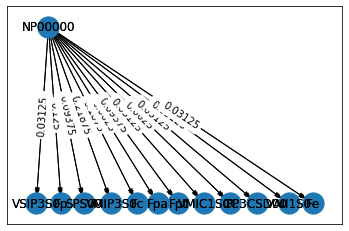

<Figure size 216x288 with 0 Axes>

In [108]:

def plotChain(transitionDictionary, tag):
    G = nx.MultiDiGraph()
    G.add_node(tag)
    for transitions in transitionDictionary[tag]:
        G.add_edge(tag, transitions, weight=transitionDictionary[tag][transitions], label=transitionDictionary[tag][transitions])
    pos = nx.drawing.nx_pydot.graphviz_layout(G, prog='dot')
    nx.draw_networkx(G, pos)
    edge_labels = {(n1,n2):d['label'] for n1,n2,d in G.edges(data=True)}
    nx.draw_networkx(G, pos, node_size=450)
    nx.draw_networkx_edge_labels(G , pos, edge_labels=edge_labels)
    plt.figure(figsize=(3,4))
    # Show the plot
    plt.show()
    #plt.clf() 
    #nx.drawing.nx_pydot.write_dot(G, 'pet_dog_markov.dot')

plotChain(typeTransictionProbabilityDictionary, "NP00000")       

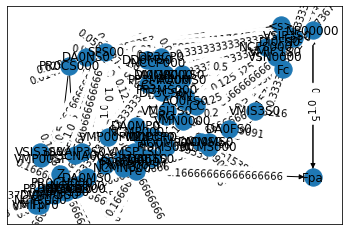

In [83]:
# Dibujo de todas las transiciones

states=typeTransictionProbabilityDictionary.keys()
G = nx.MultiDiGraph()
#G = nx.random_geometric_graph(200, 0.125)

# nodes correspond to states
states=typeTransictionProbabilityDictionary.keys()
G.add_nodes_from(typeTransictionProbabilityDictionary.keys())
#print(f'Nodes:\n{G.nodes()}\n')

for key, value in typeTransictionProbabilityDictionary.items():
    for transition in value:
        tmp_origin, tmp_destination, prob = key, transition, value[transition]
        G.add_edge(tmp_origin, tmp_destination, weight=prob, label=prob)
#print(f'Edges:')
#ppr.pprint(G.edges(data=True))
pos = nx.drawing.nx_pydot.graphviz_layout(G, prog='dot')
nx.draw_networkx(G, pos)

# create edge labels for jupyter plot but is not necessary
edge_labels = {(n1,n2):d['label'] for n1,n2,d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G , pos, edge_labels=edge_labels)
nx.drawing.nx_pydot.write_dot(G, 'pet_dog_markov.dot')
        

# Inicio de la práctica

## Implementación en Python del etiquetador morfosintáctico basado en un HMM bigrama a partir de un corpus etiquetado.

Lo primero que haremos será leer el corpus proporcionado, acto seguido creamos las matrices de observación y transición. Una vez creadas calculamos sus probabilidades asociadas:

In [4]:
# Leemos el fichero proporcionado con el corpus asociado en formato EAGLE
file = open('./mia07_t3_ag_Corpus-tagged.txt' , 'r+')
lines = file.readlines()
file.close()

# Creamos las matrizces de Obdsrevacion y transicion para poder calcular las propabilidades 
typeTransictionDictionary = {}
typeObservationDictionary = {}

# Generamos las matrices con los valores
typeTransictionDictionary, typeObservationDictionary = populateMatrix(lines, typeTransictionDictionary, typeObservationDictionary)

# Calculamos las probabilidades asociadas de observación de lemas y de transición de etiquetas
typeTransictionProbabilityDictionary = calculateProbabilities(typeTransictionDictionary)
typeObservationProbabilityDictionary = calculateProbabilities(typeObservationDictionary)   

Representamos gráficamente la frecuencia de aparación de los elementos en la matriz de transición:

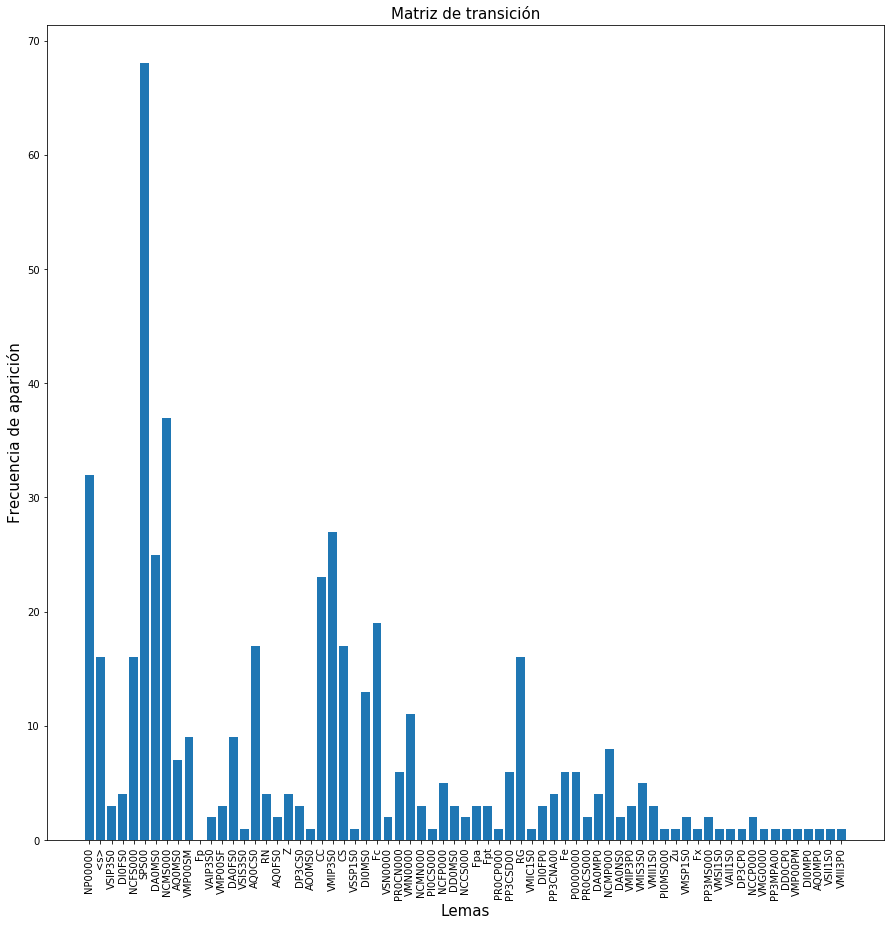

In [5]:
plotMatrixFreq(typeTransictionDictionary, 'Lemas', 'Frecuencia de aparición', 'Matriz de transición')

Representamos gráficamente la frecuencia de aparación de los elementos en la matriz de observación:

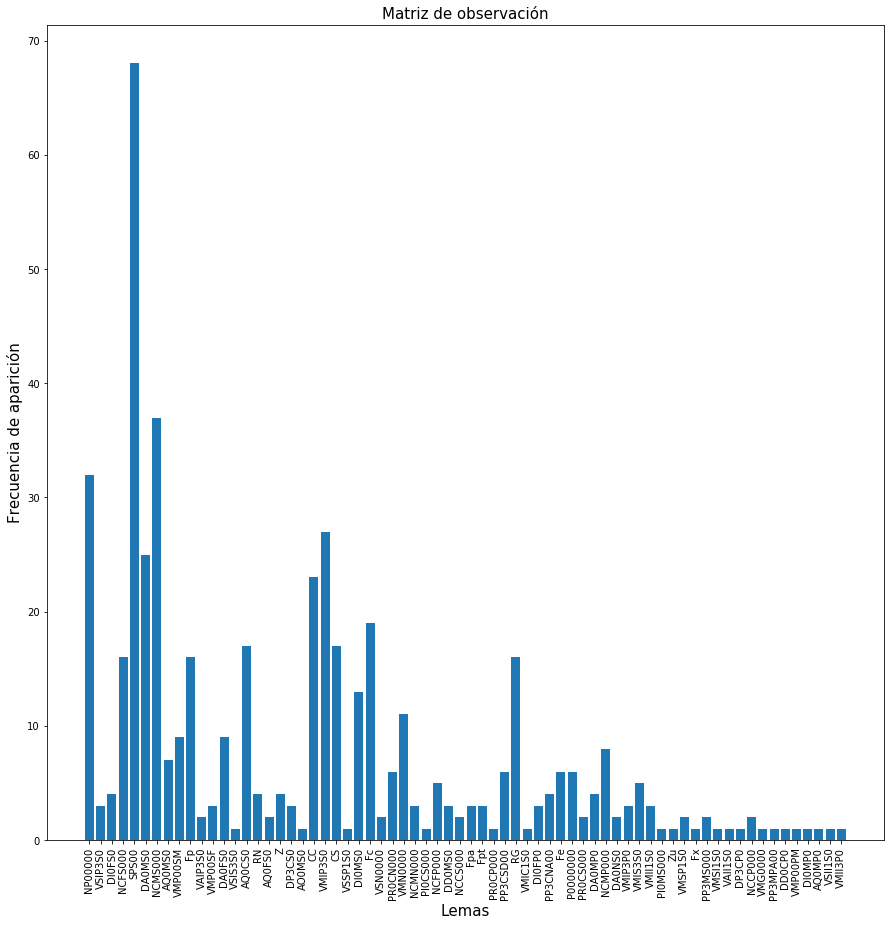

In [6]:
plotMatrixFreq(typeObservationDictionary, 'Lemas', 'Frecuencia de aparición', 'Matriz de observación')

Representamos las probabilidades de la matriz de observación:

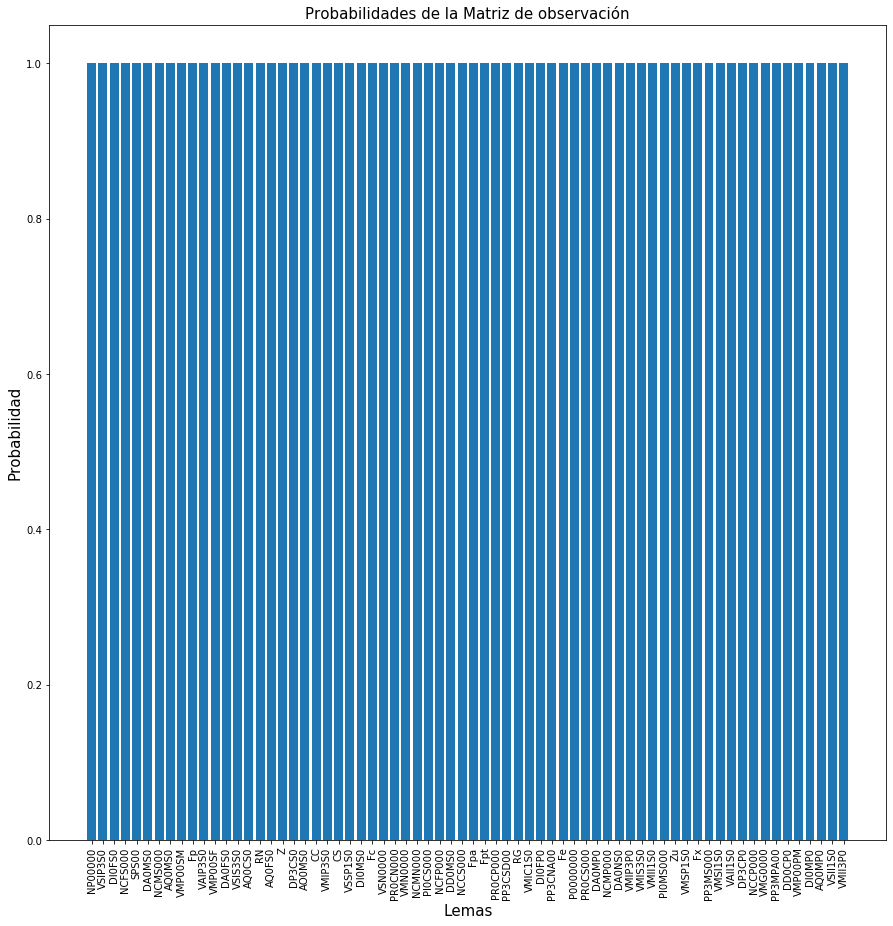

In [7]:
# Esto es inutil y no da información (intentar pintar lo que ha dicho jorge)
plotMatrixFreq(typeObservationProbabilityDictionary, 'Lemas', 'Probabilidad', 'Probabilidades de la Matriz de observación')

Representamos las probabilidades de la matriz de transición:

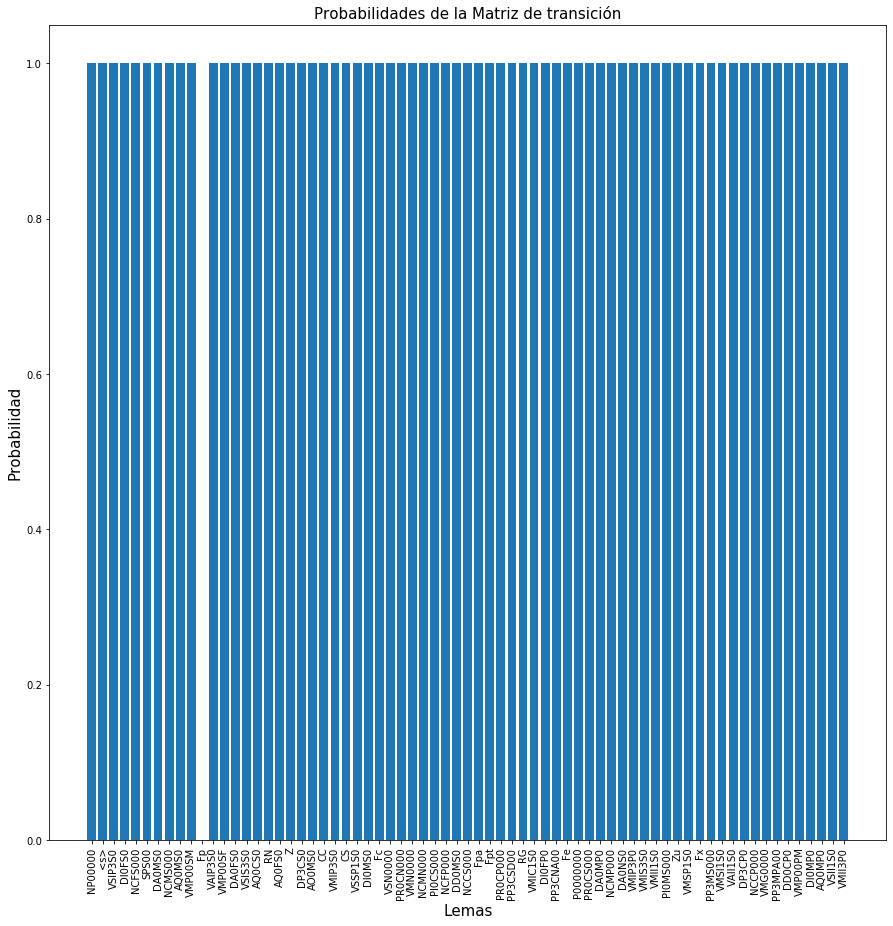

In [8]:
# Esto es inutil y no da información (intentar pintar lo que ha dicho jorge)
plotMatrixFreq(typeTransictionProbabilityDictionary, 'Lemas', 'Probabilidad', 'Probabilidades de la Matriz de transición')

## Implementación en Python de un programa que permita calcular la mejor secuencia de etiquetas para una oración, dicho de otro modo, realizar el etiquetado morfosintáctico de la oración.

Implementamos el algoritmo de Viterbi.

In [9]:
path = ""

# Implementamos una serie de funciones auxiliares para ser usadas en la implementación del algoritmo de Viterbi

'''
   Función: Función que inicializa la matriz
             - xLen: Tamaño de la matriz
             - posTags: Tags
             
   Output: 
             - Devuelve la matriz inicializada
'''

def initializeMatrix(xLen, posTags):
    outputMatrix = {}
    for i in range(xLen + 1):
        outputMatrix[i] = {}
        for posTag in posTags:
            outputMatrix[i][posTag] = 0
    return outputMatrix

'''
   Función: Devuelve la probilidad asociada a un token específico en una matriz concreta
             - dictionary: diccionario con las probabilidades
             - basedOn: matriz
             - probabilityOf: probabilidad buscada
             
   Output: 
             - Devuelve la probilidad asociada a un token específico en una matriz concreta
'''

def getProbability(dictionary, basedOn, probabilityOf):
    if basedOn in dictionary:
        if probabilityOf in dictionary[basedOn]:
            return dictionary[basedOn][probabilityOf] #Probabilidad buscada 
    return 0

'''
   Función: Limpieza de elementos espurios para asegurarnos y no tener errores que con tokenizer se eliminarian
             - sentence: frase a limpiar
             
   Output: 
             - Devuelve la frase "limpia"
'''

def sentenceCleanup(sentence):
    tokens = ['.', '/', '(', ')', ',']
    output = sentence.lower()
    for token in tokens:
        output = output.replace(token, ' ' + token + ' ')
    return output.split()

'''
   Función: Algoritmo de Viterbi
             - sentence: Input a calcular el algoritmo de Viterbi
             - observationProbabilities: Matriz de probabilidades de observación
             - transictionProbabilities: Matriz de probabilidades de transición
             
   Output: 
             - Devuelve el path calculado por el algoritmo de Viterbi
'''

def calculateViterbiPath(sentence, observationProbabilities, transictionProbabilities):
    sentenceList = sentenceCleanup(sentence) # Aseguramos la elimación de elementos erróneos
    #print(sentenceList) 
    sentenceLen = len(sentenceList)
    posTagCount = len(transictionProbabilities)
    viterbiValues = initializeMatrix(sentenceLen + 1, transictionProbabilities)
    # Recorremos cada morfema de la frase pasada como parámetro
    path = ""
    for tokenIndex in range(sentenceLen + 1):
        # Variable auxiliar para almacenar el tag con el valor máximo por morfema
        maxPosTagTo = ''
        if (tokenIndex == 0): # Elemento start 
            viterbiValues[tokenIndex]['<s>'] = 1
        else:
            # Morfema que estamos tratando. Los ponemos todos en minúsculas para evitar duplicidades.
            token = sentenceList[tokenIndex - 1].lower() 
            print("Token: " + token)
            # Inicio del path
            for posTagTo in transictionProbabilities:
                # Destino del path
                for posTagFrom in transictionProbabilities:                    
                    # Calculamos las probabilidades tanto de trasición como de observación para 
                    # elaborar el camino
                    transictionProbability = getProbability(transictionProbabilities, posTagFrom, posTagTo)
                    observationProbability = getProbability(observationProbabilities, posTagTo, token)
                    newValue = viterbiValues[tokenIndex-1][posTagFrom] * transictionProbability * observationProbability
                    currentValue = viterbiValues[tokenIndex][posTagTo]
                    
                    # Se nos pide mostrar TODAS LAS CELDAS de viterbi
                    #TODO ¿Lo dejamos? No sé... ensucia más que aclara...
                    '''
                    print('------------------------------------------------------------------------------------')
                    print('Observación de :' + str(token) + ' hacia ' + str(posTagTo) + '= ' + str(observationProbability))
                    print('Transicion desde: ' +  str(posTagFrom) + ' hasta ' + str(posTagTo) + str(transictionProbability))
                    print('Valor de Viterbi(' + str(tokenIndex-1) + ')' + '(' + str(posTagFrom) + ') = ' + str(newValue))
                    print('Valor de Viterbi(' + str(tokenIndex) +  ')' + '(' + str(posTagTo) + ') = ' + str(newValue))
                    print('------------------------------------------------------------------------------------')
                    '''                    
                    # Solo seleccionamos el máximo para la correcta implementación del algoritmo 
                    # (el valor ya se multiplica con las probabilidades)
                    if (newValue > currentValue):
                        viterbiValues[tokenIndex][posTagTo] = newValue
                        # Imprimimos el path
                        msg = 'Desde ' + posTagFrom + ' hacia ' + posTagTo + '. En el token "' + token
                        msg += '" con probabilidad: '  + str(newValue)
                        print(msg)
                        
                        # Almacenmos el tag para el valor máximo del morfema.
                        maxPosTagTo = posTagTo                        

        # En el path incluimos solo el máximo para devolver el etiquetado morfosintáctico
        if maxPosTagTo != '':
            path += " " + str(token) + "/" + str(maxPosTagTo)
                
    return path        

## Etiqueta la oración "Habla con el enfermo grave de trasplantes."

El path de Viterbi de la oración "**Habla con el enfermo grave de transplantes.**" es el siguiente:

In [10]:
sentence = "Habla con el enfermo grave de trasplantes."
etiqMS = calculateViterbiPath(sentence, typeObservationProbabilityDictionary, typeTransictionProbabilityDictionary)

Token: habla
Desde <s> hacia VMIP3S0. En el token "habla" con probabilidad: 0.009259259259259259
Token: con
Desde VMIP3S0 hacia SPS00. En el token "con" con probabilidad: 0.0001765109335915436
Token: el
Desde SPS00 hacia DA0MS0. En el token "el" con probabilidad: 4.1531984374480846e-05
Token: enfermo
Desde DA0MS0 hacia NCMS000. En el token "enfermo" con probabilidad: 2.020474915515284e-06
Desde DA0MS0 hacia AQ0MS0. En el token "enfermo" con probabilidad: 2.373256249970334e-07
Token: grave
Desde NCMS000 hacia AQ0CS0. En el token "grave" con probabilidad: 3.854642128169064e-08
Token: de
Desde AQ0CS0 hacia SPS00. En el token "de" con probabilidad: 2.5008491315975763e-09
Token: trasplantes
Desde SPS00 hacia NCMP000. En el token "trasplantes" con probabilidad: 2.7582894833796797e-11
Token: .
Desde NCMP000 hacia Fp. En el token "." con probabilidad: 3.4478618542245997e-12


### Etiquetado morfosintáctico final

In [11]:
print(etiqMS)

 habla/VMIP3S0 con/SPS00 el/DA0MS0 enfermo/AQ0MS0 grave/AQ0CS0 de/SPS00 trasplantes/NCMP000 ./Fp


## Una vez hayas creado el etiquetador morfosintáctico y lo hayas utilizado para etiquetar la oración "Habla con el enfermo grave de trasplantes.", reflexiona sobre los resultados obtenidos, interprétalos y analiza el rendimiento del etiquetador creado y sus limitaciones. 

### ¿Es correcto el etiquetado morfosintáctico que has obtenido? Indica por qué.
Vemos claramente  que el analizador ha funcionado correctamente asignando las mayores probabilidades a los términos correctamente y escogiendo el mejor path en aquellos casos de más de una transicion posible, escogiendo el maximo entre las mismas. 
Así podemos observar que para:
+ **HABLA** : lo etiqueta como Verbo General Indicativo Personal de Tercera persona del Singular
+ **CON** :  lo etiqueta perfectamente como una adposición - preposición (SP)
+ **EL** :  lo etiqueta concretamente como un determinante articulo MAsculino Singular
+ **ENFERMO**: En este caso, tenemos dos valores para el termino enfermo. Nombre y Adjetivo. Observamos que la probabilida de nombre es mayor que la de Adjetivo AQ 2.3 e-07 y NC 2.02 e-06, ergo lo está etiquetando tambien correctamente ademas observamos que la transicion siguiente es desde NCMS000 que es NOMBRE COMUN.
+ **GRAVE**: lo etiqueta como adjetivo cualitativo correctemente
+ **DE**: lo etiqueta correctamente como preposicion SP
+ **TRASPLANTES**: lo etiqueta correctamente como un nombre Comun.

En definitiva, **todos los morfemas de la oración los ha etiqueta correctemente**.

### Indica el resultado de etiquetar la oración "El enfermo grave habla de trasplantes." utilizando el etiquetador morfosintáctico. ¿Es correcto el etiquetado morfosintáctico que has obtenido? Indica por qué.  
Ejecutamos nuestro analizador con la frase pedida

In [12]:
sentence = "El enfermo grave habla de trasplantes."
etiqMS = calculateViterbiPath(sentence, typeObservationProbabilityDictionary, typeTransictionProbabilityDictionary)

Token: el
Token: enfermo
Token: grave
Token: habla
Token: de
Token: trasplantes
Token: .


Observamos que efectivamente el analisis no es correcto. Esto es debido a que en el corpus sumnistrado para el ejercicio no hay ninguna frase que empiece por un artículo singular masculino. (se ha comprobado igualmente de forma manual para asegurarnos) Esto implica que, como el corpus es incompleto, el etiquetado morfo sintáctico no se pueda llevar acabo.

### ¿Cuáles son las limitaciones del analizador morfosintáctico que has creado?

Precisamente como hemos visto anteriormente el haber generado las matrices de observación y transición a partir de un corpus incompleto no pudiendose evaluar muchas variantes del lenguaje, por ejemplo vemos que las frases que comienzan con un articulo masculino singular, no los puede analizar.

In [13]:
sentence = " el corazon con quien entabla amistad."
etiqMS = calculateViterbiPath(sentence, typeObservationProbabilityDictionary, typeTransictionProbabilityDictionary)

Token: el
Token: corazon
Token: con
Token: quien
Token: entabla
Token: amistad
Token: .


al igual que las que empiezan con un nombre comun

In [14]:
sentence = "Corazon con quien entabla amistad."
etiqMS = calculateViterbiPath(sentence, typeObservationProbabilityDictionary, typeTransictionProbabilityDictionary)

Token: corazon
Token: con
Token: quien
Token: entabla
Token: amistad
Token: .


siendo pues un analizador bastante limitado.

### ¿Qué posibles mejoras se podrían aplicar para mejorar el rendimiento del etiquetador morfosintáctico creado?

Se podrían crear reglas de exclusión en el lenguaje de tal manera que se minimizara el recorrido y todas las variantes que se tienen que calcular en las matrices. 

La reglas de exclusión serían combinaciones de estados que el propio lenguaje no puede aaprecer por no ser correcto gramaticalmente. De esta manera se chequearía si existe una transcición en la lista de exclusión, y con esto no habría que evaluar ni calcular las probabilidades de t<sub>i-1</sub> a t<sub>i</sub> puesto que no tendría sentido al no ser una combinación correcta, ofreciendo de esta manera un mejor rendimiento a nivel computacional e igualmetne a nivel de almacenamiento de memoria. 